# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



# 1) Business Understanding

The key questions of this project are the following:

a) Which groups of people are most responsive to offers?

b) Is there a difference between different offer types?

c) How best to present each type of offer?

Problem Statement: In order to answer the questions above it is important to define when an offer was successfull. As described in the task, an offer can be completed without being viewed. So it is important to control for this factor. Moreover, every offer has a validity period that needs to be considered. In order to solve this challenge a clear definition of when an order was successfull is necessary: 

Depending on the type the following sequence shall be followed:

a) for BOGO and discount offers: offer received, offer viewed, offer completed within the given time frame and in this order.

b) for informational offer: offer received, offer viewed, transaction, all within the given time frame and in this order.

The corresponding variables will be calculated under 3a, as a basis for answering the questions above.  

In [1]:
#To start the project it is important to import following libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# 2) Data Understanding/Exploration

Gathering the data: there are three files available. The description of each file can be found in the project description above. 

In [2]:
# read in the json files
portfolio = pd.read_json(r'C:\Users\q623737\Downloads\Abschlusprojekt_Starbucks\portfolio.json', orient='records', lines=True)
profile = pd.read_json(r'C:\Users\q623737\Downloads\Abschlusprojekt_Starbucks\profile.json', orient='records', lines=True)
transcript = pd.read_json(r'C:\Users\q623737\Downloads\Abschlusprojekt_Starbucks\transcript.json', orient='records', lines=True)


Data Analysis: The following steps were conducted to gain a better understanding of the underlying data. 

In [3]:

# Display the first few rows of each dataset
print("Portfolio Data:")
print(portfolio.head())
print("\nProfile Data:")
print(profile.head())
print("\nTranscript Data:")
print(transcript.head())

# Descriptive Statistics
print("\nDescriptive Statistics for Profile Data:")
print(profile.describe())

print("\nDescriptive Statistics for Portfolio Data:")
print(portfolio.describe())

print("\nDescriptive Statistics for Transcript Data:")
print(transcript.describe())

# Check for missing values
print("\nMissing Values in Profile Data:")
print(profile.isnull().sum())

print("\nMissing Values in Portfolio Data:")
print(portfolio.isnull().sum())

print("\nMissing Values in Transcript Data:")
print(transcript.isnull().sum())


# Count the number of unique IDs in the transcript DataFrame
unique_id_count = transcript['person'].nunique()

print(f"Number of unique IDs in the Transcript DataFrame: {unique_id_count}")

Portfolio Data:
   reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  

Profile Data:
  gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9

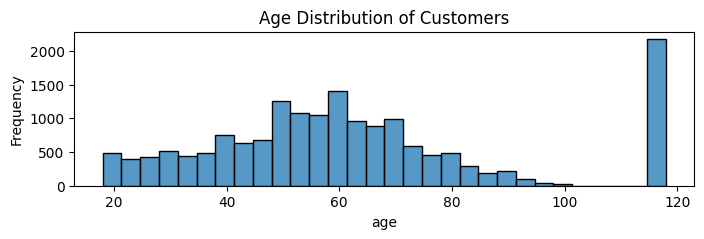

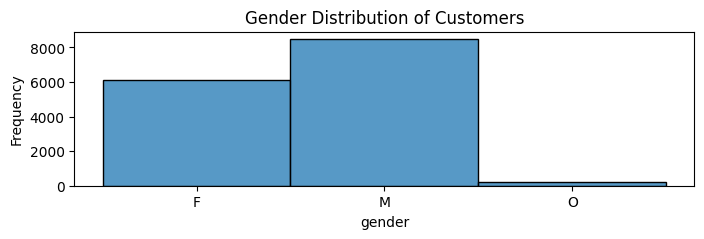

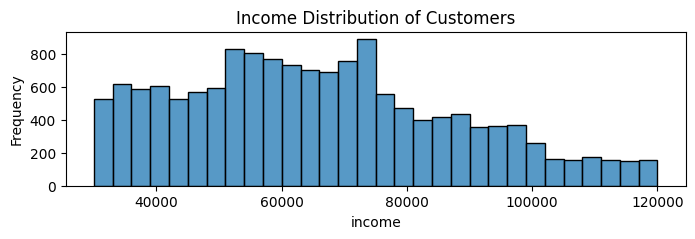

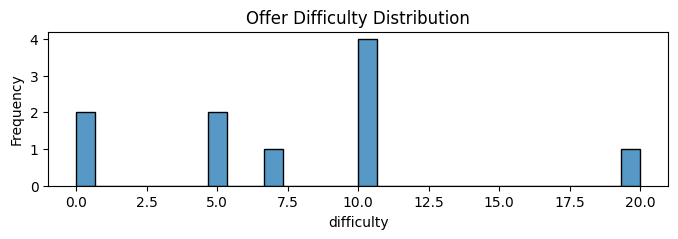

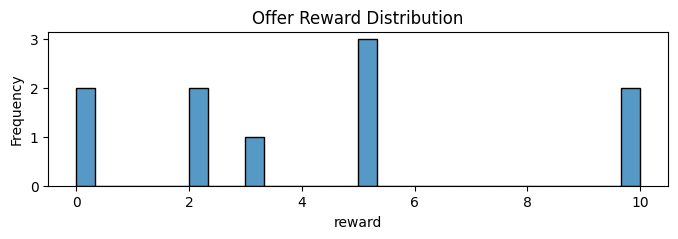

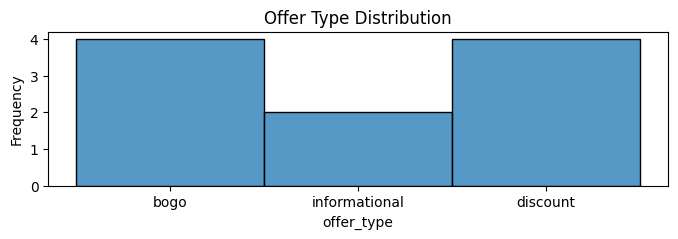

In [4]:
# Data Distribution
def plot_distribution(data, column, title):
    """
    Plots the distribution of a specified column in the given DataFrame.
    
    Parameters:
    data (DataFrame): The DataFrame containing the data to plot.
    column (str): The column name for which to plot the distribution.
    title (str): The title of the plot.
    """
    plt.figure(figsize=(8, 2))
    sns.histplot(data[column], bins=30, kde=False)
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Plot distributions for relevant columns
plot_distribution(profile, 'age', 'Age Distribution of Customers')
plot_distribution(profile, 'gender', 'Gender Distribution of Customers')
plot_distribution(profile, 'income', 'Income Distribution of Customers')
plot_distribution(portfolio, 'difficulty', 'Offer Difficulty Distribution')
plot_distribution(portfolio, 'reward', 'Offer Reward Distribution')
plot_distribution(portfolio, 'offer_type', 'Offer Type Distribution')


The descriptive statistics show some interesting features, as fore example a maximum age of 118 which is the value for missing values, leading to a high unrealistic average age of customers in the sample. 
When looking at missing values, the categories gender and income are the only columns with missing values (next to age).
There are nonly 10 offers in the portfolio dataframe. 

The following steps were conducted to receive additional KPIs (e.g. share of offers viewed), create dummy variables for answering the business questions and to merge the data sets.

In [5]:
#creating a dataframe that includes the share of offers viewed. 
# Count the number of offers received and viewed for each user ID
offers_received = transcript[transcript['event'] == 'offer received'].groupby('person').size()
offers_viewed = transcript[transcript['event'] == 'offer viewed'].groupby('person').size()

# Create a DataFrame to hold the counts
offers_summary = pd.DataFrame({
    'offers_received': offers_received,
    'offers_viewed': offers_viewed
}).fillna(0)  # Fill NaN values with 0 for users who have not received or viewed offers

# Calculate the share of viewed offers to received offers
offers_summary['viewed_share'] = offers_summary['offers_viewed'] / offers_summary['offers_received'].replace(0, np.nan)

# Display the results
print("Share of offers viewed to received for each user ID:")
print(offers_summary)

# Get descriptive statistics for the offers_summary DataFrame
descriptive_stats = offers_summary.describe()

# Display the results
print("Descriptive Statistics for the Offers Summary DataFrame:")
print(descriptive_stats)

Share of offers viewed to received for each user ID:
                                  offers_received  offers_viewed  viewed_share
person                                                                        
0009655768c64bdeb2e877511632db8f                5            4.0      0.800000
00116118485d4dfda04fdbaba9a87b5c                2            2.0      1.000000
0011e0d4e6b944f998e987f904e8c1e5                5            5.0      1.000000
0020c2b971eb4e9188eac86d93036a77                5            3.0      0.600000
0020ccbbb6d84e358d3414a3ff76cffd                4            4.0      1.000000
...                                           ...            ...           ...
fff3ba4757bd42088c044ca26d73817a                6            3.0      0.500000
fff7576017104bcc8677a8d63322b5e1                5            4.0      0.800000
fff8957ea8b240a6b5e634b6ee8eafcf                3            2.0      0.666667
fffad4f4828548d1b5583907f2e9906b                4            4.0      1.000000

In [6]:
# Merge the profile DataFrame with the transcript DataFrame on the customer ID
combined_df = pd.merge(transcript, profile, how='left', left_on='person', right_on='id')

# Drop the 'id' column as it is the same as the 'person' column
combined_df.drop(columns=['id'], inplace=True)

# Check if 'level_0' exists in offers_summary and drop it if it does
if 'level_0' in offers_summary.columns:
    offers_summary.drop(columns=['level_0'], inplace=True)

# Reset the index of offers_summary to make 'person' a column for merging
offers_summary.reset_index(inplace=True)

# Merge the combined_df with offers_summary on the 'person' column, to include the share of viewed offers to received offers
final_combined_df = pd.merge(combined_df, offers_summary, how='left', left_on='person', right_on='person')

# Reset the index of the final_combined_df DataFrame
final_combined_df.reset_index(drop=True, inplace=True)

# If 'level_0' exists, drop it from the final_combined_df DataFrame
if 'level_0' in final_combined_df.columns:
    final_combined_df.drop(columns=['level_0'], inplace=True)

# Display the first few rows of the final combined DataFrame
print("Final Combined DataFrame with Offers Summary:")
print(final_combined_df.head())

Final Combined DataFrame with Offers Summary:
                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time gender  age  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0      F   75   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0   None  118   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0      M   68   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0   None  118   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0   None  118   

   became_member_on    income  offers_received  offers_viewed  viewed_share  
0          20170509  100000.0              4.0            4.0          1.00  
1          20170804       Na

In [7]:
# Create 'female' column: 1 if gender is 'F', 0 otherwise
final_combined_df['female'] = (final_combined_df['gender'] == 'F').astype(int)

# Create 'male' column: 1 if gender is 'M', 0 otherwise
final_combined_df['male'] = (final_combined_df['gender'] == 'M').astype(int)

# Exclude entries whith missing age (age=118) 
final_combined_df= final_combined_df[(final_combined_df['age'] <= 118)]

print("\nDescriptive Statistics for final_combined_df:")
print(final_combined_df.describe())


Descriptive Statistics for final_combined_df:
                time            age  became_member_on         income  \
count  306534.000000  306534.000000      3.065340e+05  272762.000000   
mean      366.382940      60.909367      2.016545e+07   64337.000755   
std       200.326314      26.032030      1.190460e+04   21243.762941   
min         0.000000      18.000000      2.013073e+07   30000.000000   
25%       186.000000      43.000000      2.016032e+07   48000.000000   
50%       408.000000      57.000000      2.017041e+07   62000.000000   
75%       528.000000      72.000000      2.017113e+07   78000.000000   
max       714.000000     118.000000      2.018073e+07  120000.000000   

       offers_received  offers_viewed   viewed_share         female  \
count    306514.000000  306514.000000  306514.000000  306534.000000   
mean          4.674266       3.643122       0.783118       0.368967   
std           1.011795       1.246758       0.217457       0.482526   
min           1.0000

In [8]:
#In preparation to store the information from the value column in seperate columns, it is useful to check the keys used: 
#  Initialize a set to store unique keys
unique_keys = set()

# Iterate through the 'value' column
for entry in final_combined_df['value']:
    if isinstance(entry, dict):  
        unique_keys.update(entry.keys()) 

# Display the unique keys found in the 'value' column
print("Unique keys in the 'value' column:")
print(unique_keys)

Unique keys in the 'value' column:
{'amount', 'offer id', 'reward', 'offer_id'}


In [9]:
def extract_amounts(value):
    """
    Extracts the transaction amount and reward amount from the 'value' column.

    Parameters:
    value (dict or other): The value from the 'value' column, which may be a dictionary containing an 'amount' or 'reward' key.

    Returns:
    tuple: A tuple containing the transaction amount and reward amount.
    """
    transaction_amount = 0
    reward_amount = 0
    
    if isinstance(value, dict):
        if 'amount' in value:
            transaction_amount = value['amount']
        if 'reward' in value:
            reward_amount = value['reward']
    
    return transaction_amount, reward_amount

# Create the 'transaction_amount' and 'reward_amount' columns
final_combined_df[['transaction_amount', 'reward_amount']] = final_combined_df['value'].apply(extract_amounts).apply(pd.Series)



In [10]:
# Create a new DataFrame with unique users and the sum of transaction amounts
user_transaction_summary = final_combined_df.groupby('person').agg(
    transaction_amount_sum=('transaction_amount', 'sum')
).reset_index()


# Merge the transaction_amount_sum back into final_combined_df
final_combined_df = pd.merge(final_combined_df, user_transaction_summary, how='left', on='person')


In [11]:
def extract_offer_id(value):
    """
    Extracts the offer ID from the 'value' column.

    Parameters:
    value (dict or other): The value from the 'value' column, which may be a dictionary containing an 'offer id' or 'offer_id' key.

    Returns:
    str or int: The offer ID if the 'value' is a dictionary containing either the 'offer id' or 'offer_id' key; 
                returns 0 if it contains 'amount'; 
                otherwise returns None.
    """
    if isinstance(value, dict):
        # Check for both 'offer id' and 'offer_id' keys
        if 'offer id' in value:
            return value['offer id']
        elif 'offer_id' in value:
            return value['offer_id']
        elif 'amount' in value:
            return 0
    return None  # Return None if neither condition is met

# Create the 'offer_id' column
final_combined_df['offer_id'] = final_combined_df['value'].apply(extract_offer_id)

# Display the first few rows of the final combined DataFrame to check the new column
print("Final Combined DataFrame with Offer ID:")
print(final_combined_df[['value', 'offer_id']].head())


Final Combined DataFrame with Offer ID:
                                              value  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}   

                           offer_id  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7  
2  2906b810c7d4411798c6938adc9daaa5  
3  fafdcd668e3743c1bb461111dcafc2a4  
4  4d5c57ea9a6940dd891ad53e9dbe8da0  


In [12]:
## Merging again, this time Portfolio data
# Merge final_combined_df with portfolio on the offer_id and id columns
final2_combined_df = pd.merge(final_combined_df, portfolio, how='left', left_on='offer_id', right_on='id', suffixes=('', '_portfolio'))

# Drop the 'id' column from the merged DataFrame 
final2_combined_df.drop(columns=['id'], inplace=True)

# Display the first few rows of the merged DataFrame
print("Merged DataFrame with Portfolio:")
print(final2_combined_df.head())

Merged DataFrame with Portfolio:
                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time gender  age  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0      F   75   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0   None  118   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0      M   68   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0   None  118   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0   None  118   

   became_member_on    income  offers_received  offers_viewed  ...  male  \
0          20170509  100000.0              4.0            4.0  ...     0   
1          20170804       NaN              5.

In [13]:

# Create dummy variables for the different offer types
final2_combined_df['offer_bogo'] = (final2_combined_df['offer_type'].str.lower() == 'bogo').astype(int)
final2_combined_df['offer_discount'] = (final2_combined_df['offer_type'].str.lower() == 'discount').astype(int)
final2_combined_df['offer_informational'] = (final2_combined_df['offer_type'].str.lower() == 'informational').astype(int)

# Display the first few rows of the final combined DataFrame to check the new column
print("Final Combined DataFrame with Offer Bogo Column:")
print(final2_combined_df[['offer_type', 'offer_bogo','offer_discount','offer_informational']].head())



Final Combined DataFrame with Offer Bogo Column:
  offer_type  offer_bogo  offer_discount  offer_informational
0       bogo           1               0                    0
1   discount           0               1                    0
2   discount           0               1                    0
3   discount           0               1                    0
4       bogo           1               0                    0


In [14]:
def create_channel_dummies(channels):
    """
    Creates dummy variables for the channels present in the 'channels' list.

    Parameters:
    channels (list or float): A list of channels that may include 'web', 'email', 'mobile', and 'social'.
                              If the value is NaN, it will be treated as an empty list.

    Returns:
    dict: A dictionary with dummy variables for each channel.
    """
    # Initialize dummy variables
    if isinstance(channels, list):
        return {
            'web': 1 if 'web' in channels else 0,
            'email': 1 if 'email' in channels else 0,
            'mobile': 1 if 'mobile' in channels else 0,
            'social': 1 if 'social' in channels else 0
        }
    else:
        # If channels NaN, return all 0s
        return {
            'web': 0,
            'email': 0,
            'mobile': 0,
            'social': 0
        }

# Create dummy columns for each channel
channel_dummies_df = final2_combined_df['channels'].apply(create_channel_dummies).apply(pd.Series)

In [15]:
# Merge the dummy columns back into the final_combined_df DataFrame
final2_combined_df = pd.concat([final2_combined_df, channel_dummies_df], axis=1)


In [16]:
# Display all column names of the final_combined_df DataFrame
print("Column names in final_combined_df:")
print(final2_combined_df.columns.tolist())

Column names in final_combined_df:
['person', 'event', 'value', 'time', 'gender', 'age', 'became_member_on', 'income', 'offers_received', 'offers_viewed', 'viewed_share', 'female', 'male', 'transaction_amount', 'reward_amount', 'transaction_amount_sum', 'offer_id', 'reward', 'channels', 'difficulty', 'duration', 'offer_type', 'offer_bogo', 'offer_discount', 'offer_informational', 'web', 'email', 'mobile', 'social']


In [17]:
print("\nDescriptive Statistics for final2_combined_df:")
print(final2_combined_df.describe())

# Check for missing values
print("\nMissing Values in final2_combined_df:")
print(final2_combined_df.isnull().sum())




Descriptive Statistics for final2_combined_df:
                time            age  became_member_on         income  \
count  306534.000000  306534.000000      3.065340e+05  272762.000000   
mean      366.382940      60.909367      2.016545e+07   64337.000755   
std       200.326314      26.032030      1.190460e+04   21243.762941   
min         0.000000      18.000000      2.013073e+07   30000.000000   
25%       186.000000      43.000000      2.016032e+07   48000.000000   
50%       408.000000      57.000000      2.017041e+07   62000.000000   
75%       528.000000      72.000000      2.017113e+07   78000.000000   
max       714.000000     118.000000      2.018073e+07  120000.000000   

       offers_received  offers_viewed   viewed_share         female  \
count    306514.000000  306514.000000  306514.000000  306534.000000   
mean          4.674266       3.643122       0.783118       0.368967   
std           1.011795       1.246758       0.217457       0.482526   
min           1.000

In [44]:
# there are 19 lines with missing data on offers received, offers_viewed. I exclude them due to the low number.
final2_combined_df = final2_combined_df.dropna(subset=['offers_received'])

# Drop rows where age is 118
final2_combined_df= final2_combined_df[final2_combined_df['age'] != 118].copy()

# Check for missing values
print("\nMissing Values in final2_combined_df:")
print(final2_combined_df.isnull().sum())


Missing Values in final2_combined_df:
person                         0
event                          0
value                          0
time                           0
gender                         0
age                            0
became_member_on               0
income                         0
offers_received                0
offers_viewed                  0
viewed_share                   0
female                         0
male                           0
transaction_amount             0
reward_amount                  0
transaction_amount_sum         0
offer_id                       0
reward                    123938
channels                  123938
difficulty                123938
duration                  123938
offer_type                123938
offer_bogo                     0
offer_discount                 0
offer_informational            0
web                            0
email                          0
mobile                         0
social                         0
dura

# 3. Evaluate the Business Questions

Pre-condition: Defining a successfull offer - depending on the type the following sequence shall be followed (as described above):

a) for BOGO and discount offers: offer received, offer viewed, offer completed within the given time frame (defined by duration)

b) for informational offer: offer received, offer viewed, transaction, all within the given time frame (defined by duration)

In [19]:
#Defining duration in minutes (same unit as time variable)
final2_combined_df['duration_hours'] = final2_combined_df['duration'] * 24



In [20]:

# Create a new column 'time_frame_end' indicating the end of the offer validity
final2_combined_df['time_frame_end'] = 0
# Fill in 'time_frame_end' for rows where the event is 'offer received'
final2_combined_df.loc[final2_combined_df['event'] == 'offer received', 'time_frame_end'] = (
    final2_combined_df['time'] + final2_combined_df['duration_hours']  
)



In [21]:
# Initialize the new column 'time_viewed' with NaN to store the time the offer was viewed in a seperate column
final2_combined_df['time_viewed'] = 0

#Set the 'time_viewed' value where the event is 'offer viewed'
final2_combined_df.loc[final2_combined_df['event'] == 'offer viewed', 'time_viewed'] = final2_combined_df['time']


In [22]:

def check_offer_viewed(group):

    """
    Check if offers were viewed within their valid time frame for a group of events.
    Checks for valid views based on time, person, and offer_id.

    Parameters:
    group (pandas.DataFrame): Group of events for a specific offer.

    Returns:
    pandas.DataFrame: 'offer received' events with 'offer_viewed_in_time' status.

    """
    received = group[group['event'] == 'offer received'].copy()
    viewed = group[group['event'] == 'offer viewed'].copy()
    
    # Initialize a column for the result
    received['offer_viewed_in_time'] = False
    
    for idx, rec in received.iterrows():
        valid_views = viewed[
            (viewed['time_viewed'] >= rec['time']) & 
            (viewed['time_viewed'] < rec['time_frame_end'])&
            (viewed['person'] == rec['person'])&
            (viewed['offer_id'] == rec['offer_id'])
        ]
        if not valid_views.empty:
            received.at[idx, 'offer_viewed_in_time'] = True
    
    return received[['time', 'time_frame_end', 'offer_viewed_in_time']]


In [23]:
# Copy the existing dataframe
df2 = final2_combined_df.copy()
# Sort the dataframe by user, offer_id, and time
df2 = df2.sort_values(['person', 'offer_id', 'time'])


In [24]:
# Group by person and offer_id
grouped2 = df2.groupby(['person', 'offer_id'])
# Apply the check_offer_viewed function to each group
result2 = grouped2.apply(check_offer_viewed)



C:\Users\q623737\AppData\Local\Temp\ipykernel_13196\1141697898.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result2 = grouped2.apply(check_offer_viewed)


In [25]:
# Reset the index to flatten the result
result2 = result2.reset_index()

# Merge the result back to the original dataframe
final3_df = pd.merge(df2, result2, 
                    on=['person', 'offer_id', 'time', 'time_frame_end'], 
                    how='left')

In [26]:
# Create the new column 'offer_viewed_in_time2'
final3_df['offer_viewed_in_time2'] = final3_df['offer_viewed_in_time'].map({True: 1, False: 0})

# For rows where 'offer_viewed_in_time' is NaN, set 'offer_viewed_in_time2' to NaN as well
final3_df.loc[final3_df['offer_viewed_in_time'].isna(), 'offer_viewed_in_time2'] = np.nan

# Verify the conversion
print(final3_df[['offer_viewed_in_time', 'offer_viewed_in_time2']].head(10))



  offer_viewed_in_time  offer_viewed_in_time2
0                  NaN                    NaN
1                  NaN                    NaN
2                  NaN                    NaN
3                  NaN                    NaN
4                  NaN                    NaN
5                  NaN                    NaN
6                  NaN                    NaN
7                  NaN                    NaN
8                False                    0.0
9                  NaN                    NaN


In [27]:
#rename the dataframe for simplicity
df=final3_df.copy()

In [28]:
# for point a) check the completion of bogo and discount offers 
def check_offer_completed(group):
    """
    Check if offers were completed within the valid time frame after being viewed.

    Parameters:
    group (pandas.DataFrame): Group of events for a specific person and offer_id.

    Returns:
    pandas.DataFrame: DataFrame with 'offer_completed_in_time' for each offer received instance.
    """
    viewed = group[(group['event'] == 'offer viewed') & (group['offer_type'].isin(['bogo', 'discount']))].copy()
    completed = group[group['event'] == 'offer completed']
    received = group[group['event'] == 'offer received']
    
    # Initialize the result column
    received['offer_completed_in_time'] = False
    
    for idx, rec in received.iterrows():
        # Find relevant view events for this offer instance
        relevant_views = viewed[
            (viewed['time'] >= rec['time']) & 
            (viewed['time'] < rec['time_frame_end'])
        ]
        
        for _, view in relevant_views.iterrows():
            # Check for completions after viewing and before offer expiration
            valid_completions = completed[
                (completed['time'] > view['time']) & 
                (completed['time'] <= rec['time_frame_end'])
            ]
            
            if not valid_completions.empty:
                received.at[idx, 'offer_completed_in_time'] = True
                break  # Move to next offer instance once we find a completion
    
    return received[['time', 'time_frame_end', 'offer_completed_in_time']]


In [29]:
# Filter for relevant offer types
relevant_df = df[df['offer_type'].isin(['bogo', 'discount'])]

# Group by person and offer_id, and apply the check_offer_completed function
result = relevant_df.groupby(['person', 'offer_id']).apply(check_offer_completed)

# Reset the index to flatten the result
result = result.reset_index(level=[0,1])



C:\Users\q623737\AppData\Local\Temp\ipykernel_13196\1060463815.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = relevant_df.groupby(['person', 'offer_id']).apply(check_offer_completed)


In [30]:
# Merge the result back to the original dataframe
df = pd.merge(df, result, 
              on=['person', 'offer_id', 'time', 'time_frame_end'], 
              how='left')

        


In [31]:
# Convert offer_completed_in_time to numeric values
df['offer_completed_in_time2'] = df['offer_completed_in_time'].map({True: 1, False: 0})

# If there are any NaN values in offer_completed_in_time, they will be NaN in offer_completed_in_time2 as well



In [32]:
#for point b) check whether there was a transaction for informational offers within the time frame (but after the time viewed)

def check_transaction_after_view(group, transactions):
    """
    Check if there was a transaction after viewing an informational offer and before it expired,
    for a specific person and offer.

    Parameters:
    group (pandas.DataFrame): Group of events for a specific person and offer_id.
    transactions (pandas.DataFrame): All transactions for the person.

    Returns:
    pandas.DataFrame: DataFrame with 'transaction_after_view' status for each offer received.
    """
    received = group[group['event'] == 'offer received'].copy()
    viewed = group[group['event'] == 'offer viewed']
    
    received['transaction_after_view'] = False
    
    for idx, rec in received.iterrows():
        if rec['offer_viewed_in_time2'] != 1:
            continue
        
        # Find the earliest view time after this offer was received
        valid_views = viewed[(viewed['time'] >= rec['time']) & (viewed['time'] <= rec['time_frame_end'])]
        if valid_views.empty:
            continue
        
        earliest_view_time = valid_views['time'].min()
        
        # Check for transactions after the view and before offer expiration
        transactions_after_view = transactions[
            (transactions['time'] > earliest_view_time) & 
            (transactions['time'] <= rec['time_frame_end'])
        ]
        
        if not transactions_after_view.empty:
            received.at[idx, 'transaction_after_view'] = True
    
    return received[['person', 'offer_id', 'time', 'time_frame_end', 'transaction_after_view']]

# Separate informational offers and transactions
informational_offers = df[df['offer_type'] == 'informational']
transactions = df[df['event'] == 'transaction']

# Process each person separately
result_list = []
for person, person_data in informational_offers.groupby('person'):
    person_transactions = transactions[transactions['person'] == person]
    person_result = person_data.groupby('offer_id').apply(lambda x: check_transaction_after_view(x, person_transactions))
    person_result = person_result.reset_index(drop=True)  # Reset index to avoid multi-index
    result_list.append(person_result)

# Combine results
if result_list:
    result = pd.concat(result_list, ignore_index=True)

    # Merge the result back to the original dataframe
    df = pd.merge(df, result, 
                  on=['person', 'offer_id', 'time', 'time_frame_end'], 
                  how='left')

    # Convert boolean column to 1 and 0
    df['transaction_after_view_num'] = df['transaction_after_view'].map({True: 1, False: 0, np.nan: np.nan})
else:
    print("No informational offers met the criteria for transaction_after_view.")
    df['transaction_after_view'] = np.nan
    df['transaction_after_view_num'] = np.nan



C:\Users\q623737\AppData\Local\Temp\ipykernel_13196\2401933049.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  person_result = person_data.groupby('offer_id').apply(lambda x: check_transaction_after_view(x, person_transactions))
C:\Users\q623737\AppData\Local\Temp\ipykernel_13196\2401933049.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  person_result = person_data.groupby('offer_id').apply(lambda

# Question 3a: Analysis: Which group of people are most responsive to offers?

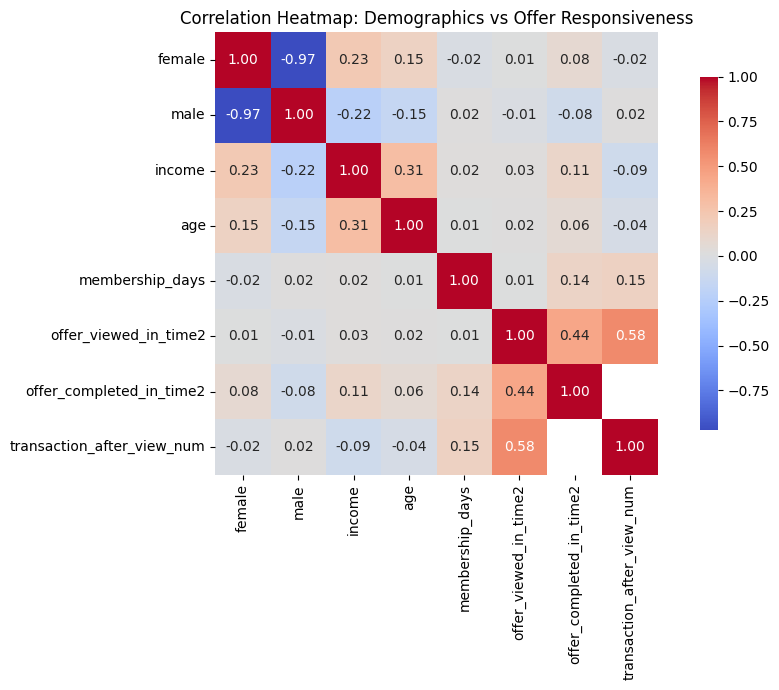


Correlation Matrix:
                              female      male    income       age  \
female                      1.000000 -0.972117  0.227527  0.149466   
male                       -0.972117  1.000000 -0.223651 -0.149364   
income                      0.227527 -0.223651  1.000000  0.305156   
age                         0.149466 -0.149364  0.305156  1.000000   
membership_days            -0.017725  0.020840  0.022914  0.008904   
offer_viewed_in_time2       0.007969 -0.014568  0.029204  0.021605   
offer_completed_in_time2    0.076492 -0.080915  0.114500  0.061478   
transaction_after_view_num -0.018701  0.016372 -0.089503 -0.042051   

                            membership_days  offer_viewed_in_time2  \
female                            -0.017725               0.007969   
male                               0.020840              -0.014568   
income                             0.022914               0.029204   
age                                0.008904               0.021605  

C:\Users\q623737\AppData\Local\Temp\ipykernel_13196\1683225835.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_response = df_received.groupby('income_quartile').agg({
C:\Users\q623737\AppData\Local\Temp\ipykernel_13196\1683225835.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_response = df_received.groupby('age_group').agg({
C:\Users\q623737\AppData\Local\Temp\ipykernel_13196\1683225835.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fu

In [33]:
df_received = df[df['event'] == 'offer received'].copy()

# Convert 'became_member_on' to datetime
df_received['became_member_on'] = pd.to_datetime(df_received['became_member_on'].astype(str), format='%Y%m%d')

# Calculate membership duration
current_date = pd.Timestamp.now()
df_received['membership_days'] = (current_date - df_received['became_member_on']).dt.days


# Select the relevant columns for the correlation matrix
columns_for_correlation = ['female', 'male', 'income', 'age', 'membership_days', 
                           'offer_viewed_in_time2', 'offer_completed_in_time2', 'transaction_after_view_num']

# Calculate the correlation matrix
correlation_matrix = df_received[columns_for_correlation].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 7))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})

# Set the title
plt.title('Correlation Heatmap: Demographics vs Offer Responsiveness')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

# Print the correlation matrix
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Calculate average response metrics by income quartile
df_received['income_quartile'] = pd.qcut(df_received['income'], q=4, labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)'])
income_response = df_received.groupby('income_quartile').agg({
    'offer_viewed_in_time2': 'mean',
    'offer_completed_in_time2': 'mean',
    'transaction_after_view_num': 'mean'
})

print("\nAverage Response Metrics by Income Quartile:")
print(income_response)

# Calculate average response metrics by age group
df_received['age_group'] = pd.cut(df_received['age'], bins=[0, 30, 45, 60, np.inf], labels=['18-30', '31-45', '46-60', '60+'])
age_response = df_received.groupby('age_group').agg({
    'offer_viewed_in_time2': 'mean',
    'offer_completed_in_time2': 'mean',
    'transaction_after_view_num': 'mean'
})

print("\nAverage Response Metrics by Age Group:")
print(age_response)

# Calculate average response metrics by membership duration quartile
df_received['membership_quartile'] = pd.qcut(df_received['membership_days'], q=4, labels=['Q1 (Newest)', 'Q2', 'Q3', 'Q4 (Oldest)'])
membership_response = df_received.groupby('membership_quartile').agg({
    'offer_viewed_in_time2': 'mean',
    'offer_completed_in_time2': 'mean',
    'transaction_after_view_num': 'mean'
})

print("\nAverage Response Metrics by Membership Duration Quartile:")
print(membership_response)



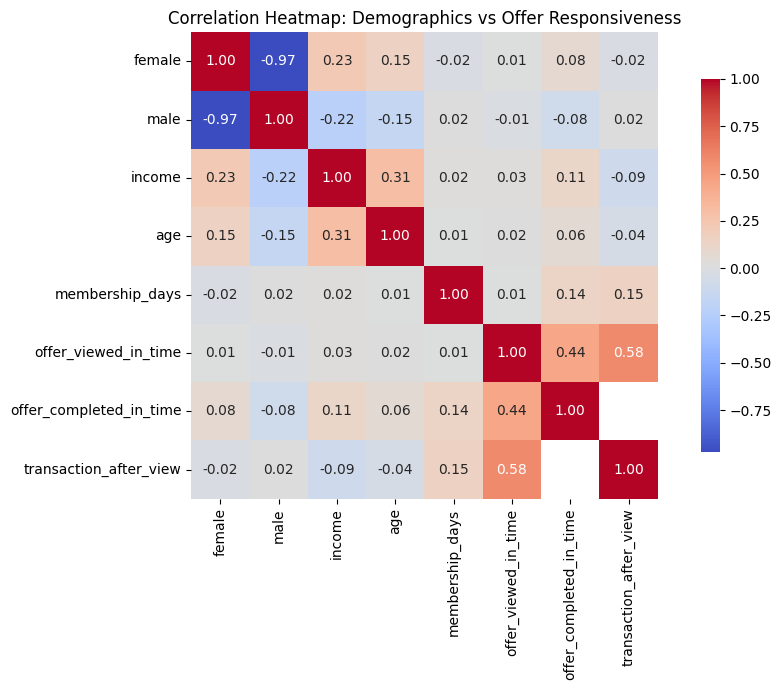

In [34]:
#renaming columns for the graph
#Select the relevant columns for the correlation matrix
columns_for_correlation = ['female', 'male', 'income', 'age', 'membership_days', 
                           'offer_viewed_in_time2', 'offer_completed_in_time2', 'transaction_after_view_num']

# Calculate the correlation matrix
correlation_matrix = df_received[columns_for_correlation].corr()

# Create a dictionary to map old names to new names
name_mapping = {
    'offer_viewed_in_time2': 'offer_viewed_in_time',
    'offer_completed_in_time2': 'offer_completed_in_time',
    'transaction_after_view_num': 'transaction_after_view'
}

# Rename the index and columns of the correlation matrix
correlation_matrix = correlation_matrix.rename(index=name_mapping, columns=name_mapping)

# Set up the matplotlib figure
plt.figure(figsize=(10, 7))

# Create a heatmap with the renamed correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})

# Set the title
plt.title('Correlation Heatmap: Demographics vs Offer Responsiveness')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

In [35]:
# Checking whether the dataframe includes person without any offers received, but still making transactions

# Identify persons who had an 'offer received' event
persons_with_offers = df[df['event'] == 'offer received']['person'].unique()

# Identify all unique persons in the dataset
all_persons = df['person'].unique()

# Step 3: Find persons who didn't receive any offer
persons_without_offers = set(all_persons) - set(persons_with_offers)

# Create the subdataframe
df_no_offers = df[df['person'].isin(persons_without_offers)]

print(f"Number of persons who didn't receive any offer: {len(persons_without_offers)}")


Number of persons who didn't receive any offer: 0


# Result for Question a)
There seems to be only a small difference between male and female customers in their response behavour. However, the longer the membership, the more likely it is that the offers are viewed and completed. The higher income has a slight impact on the offer completion rate. Higher age groups also seem to be more likely to complete an offer in time.  

# Question 3b) Analysis: Is there a difference between different offer types?

Discount Offer Success Rate: 40.93%
BOGO Offer Success Rate: 35.36%
Informational Offer Success Rate (Transaction After View): 36.86%


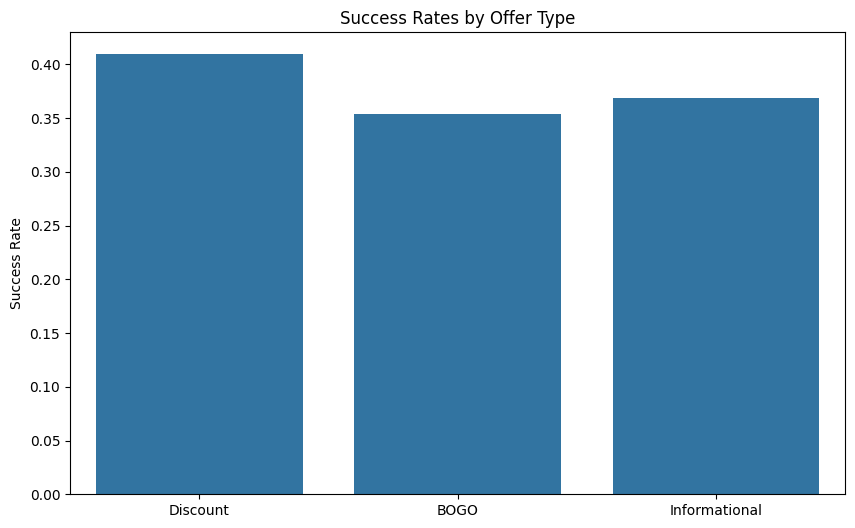


t-test for Discount vs BOGO: t-statistic = 13.2537, p-value = 0.0000


In [36]:
# Separate dataframes for each offer type
df_discount = df_received[df_received['offer_type'] == 'discount']
df_bogo = df_received[df_received['offer_type'] == 'bogo']
df_informational = df_received[df_received['offer_type'] == 'informational']

# Function to calculate success rate for discount and BOGO offers
def calc_success_rate(df):
    return df['offer_completed_in_time2'].mean()

# Calculate success rates
discount_success = calc_success_rate(df_discount)
bogo_success = calc_success_rate(df_bogo)
informational_success = df_informational['transaction_after_view_num'].mean()

# Print success rates
print(f"Discount Offer Success Rate: {discount_success:.2%}")
print(f"BOGO Offer Success Rate: {bogo_success:.2%}")
print(f"Informational Offer Success Rate (Transaction After View): {informational_success:.2%}")

# Visualize success rates
plt.figure(figsize=(10, 6))
sns.barplot(x=['Discount', 'BOGO', 'Informational'], 
            y=[discount_success, bogo_success, informational_success])
plt.title('Success Rates by Offer Type')
plt.ylabel('Success Rate')
plt.show()

# Statistical tests
# For discount vs BOGO (both use offer_completed_in_time2)
t_stat, p_value = stats.ttest_ind(df_discount['offer_completed_in_time2'], 
                                  df_bogo['offer_completed_in_time2'])
print(f"\nt-test for Discount vs BOGO: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

# For informational, we can't directly compare with others due to different success metrics


# Intermediate Result for Question b)

The results indicate a signficant difference in the success rates between discount, BOGO and informational. The t-test shows a significant higher success for discount offers, than for BOGO offers. The p-value indicates statistical significance. 

In [37]:
#Checking the influence of demographic factors on the success rates of different offer types.  

# Analyze Age for BOGO
bogo_age_correlation = df_bogo['age'].corr(df_bogo['offer_completed_in_time2'])
bogo_age_p_value = stats.pearsonr(df_bogo['age'], df_bogo['offer_completed_in_time2'])[1]
print(f"Age correlation BOGO: {bogo_age_correlation:.4f}, p-value: {bogo_age_p_value:.4f}")

# Analyze Income for BOGO
bogo_income_correlation = df_bogo['income'].corr(df_bogo['offer_completed_in_time2'])
bogo_income_p_value = stats.pearsonr(df_bogo['income'], df_bogo['offer_completed_in_time2'])[1]
print(f"Income correlation BOGO: {bogo_income_correlation:.4f}, p-value: {bogo_income_p_value:.4f}")

# Analyze Gender for BOGO
bogo_female_success = df_bogo[df_bogo['female'] == 1]['offer_completed_in_time2'].mean()
bogo_male_success = df_bogo[df_bogo['male'] == 1]['offer_completed_in_time2'].mean()
bogo_t_stat, bogo_gender_p_value = stats.ttest_ind(
    df_bogo[df_bogo['female'] == 1]['offer_completed_in_time2'],
    df_bogo[df_bogo['male'] == 1]['offer_completed_in_time2']
)

print(f"Female success rate BOGO: {bogo_female_success:.4f}")
print(f"Male success rate BOGO: {bogo_male_success:.4f}")
print(f"Gender t-statistic BOGO: {bogo_t_stat:.4f}, p-value: {bogo_gender_p_value:.4f}")

# Analyze Membership duration for BOGO
bogo_membership_correlation = df_bogo['membership_days'].corr(df_bogo['offer_completed_in_time2'])
bogo_membership_p_value = stats.pearsonr(df_bogo['membership_days'], df_bogo['offer_completed_in_time2'])[1]
print(f"Membership days correlation BOGO: {bogo_membership_correlation:.4f}, p-value: {bogo_membership_p_value:.4f}")

Age correlation BOGO: 0.0808, p-value: 0.0000
Income correlation BOGO: 0.1554, p-value: 0.0000
Female success rate BOGO: 0.4167
Male success rate BOGO: 0.3057
Gender t-statistic BOGO: 18.6728, p-value: 0.0000
Membership days correlation BOGO: 0.1053, p-value: 0.0000


Analysing the connection between BOGO and demographics:
Demographics do play a role in the success of BOGO offers, with all four factors (age, income, gender and membership duration) showing statistically significant relationships with offer completion rates, however to very different magnitudes: There is a weak positiv correlation between BOGO fullfilment and age and there is a moderate correlation between income and BOGO fullfilment. However, females seem significantly be more likely to fullfill BOGO offers than males. There is a weak positive correlation between membership duration and offer completion rate.

In [38]:
# Analyze Age for Discount
discount_age_correlation = df_discount['age'].corr(df_discount['offer_completed_in_time2'])
discount_age_p_value = stats.pearsonr(df_discount['age'], df_discount['offer_completed_in_time2'])[1]
print(f"Age correlation Discount: {discount_age_correlation:.4f}, p-value: {discount_age_p_value:.4f}")

# Analyze Income for Discount
discount_income_correlation = df_discount['income'].corr(df_discount['offer_completed_in_time2'])
discount_income_p_value = stats.pearsonr(df_discount['income'], df_discount['offer_completed_in_time2'])[1]
print(f"Income correlation Discount: {discount_income_correlation:.4f}, p-value: {discount_income_p_value:.4f}")

# Analyze Gender for Discount
discount_female_success = df_discount[df_discount['female'] == 1]['offer_completed_in_time2'].mean()
discount_male_success = df_discount[df_discount['male'] == 1]['offer_completed_in_time2'].mean()
discount_t_stat, discount_gender_p_value = stats.ttest_ind(
    df_discount[df_discount['female'] == 1]['offer_completed_in_time2'],
    df_discount[df_discount['male'] == 1]['offer_completed_in_time2']
)
print(f"Female success rate Discount: {discount_female_success:.4f}")
print(f"Male success rate Discount: {discount_male_success:.4f}")
print(f"Gender t-statistic Discount: {discount_t_stat:.4f}, p-value: {discount_gender_p_value:.4f}")

# Analyze Membership duration for Discount
discount_membership_correlation = df_discount['membership_days'].corr(df_discount['offer_completed_in_time2'])
discount_membership_p_value = stats.pearsonr(df_discount['membership_days'], df_discount['offer_completed_in_time2'])[1]
print(f"Membership days correlation Discount: {discount_membership_correlation:.4f}, p-value: {discount_membership_p_value:.4f}")


Age correlation Discount: 0.0431, p-value: 0.0000
Income correlation Discount: 0.0753, p-value: 0.0000


Female success rate Discount: 0.4352
Male success rate Discount: 0.3893
Gender t-statistic Discount: 7.4693, p-value: 0.0000
Membership days correlation Discount: 0.1686, p-value: 0.0000


Analysing the connection between discount offers and demographics: 
Demographics do play also a role in the success of discount offers, with all four factors (age, income, gender and membership duration) showing statistically significant relationships with offer completion rates. However, the effects are generally weaker than what we observed for BOGO offers. Membership duration appears to be the most important factor for discount offer success. While females are still more likely to complete Discount offers, the gender gap is smaller than for BOGO offers.

 

In [39]:
# Analyze Age for Informational offers
info_age_correlation = df_informational['age'].corr(df_informational['transaction_after_view_num'])
info_age_p_value = stats.pearsonr(df_informational['age'], df_informational['transaction_after_view_num'])[1]
print(f"Age correlation Informational: {info_age_correlation:.4f}, p-value: {info_age_p_value:.4f}")

# Analyze Income for Informational offers
info_income_correlation = df_informational['income'].corr(df_informational['transaction_after_view_num'])
info_income_p_value = stats.pearsonr(df_informational['income'], df_informational['transaction_after_view_num'])[1]
print(f"Income correlation Informational: {info_income_correlation:.4f}, p-value: {info_income_p_value:.4f}")

# Analyze Gender for Informational offers
info_female_success = df_informational[df_informational['female'] == 1]['transaction_after_view_num'].mean()
info_male_success = df_informational[df_informational['male'] == 1]['transaction_after_view_num'].mean()
info_t_stat, info_gender_p_value = stats.ttest_ind(
    df_informational[df_informational['female'] == 1]['transaction_after_view_num'],
    df_informational[df_informational['male'] == 1]['transaction_after_view_num']
)
print(f"Female success rate Informational: {info_female_success:.4f}")
print(f"Male success rate Informational: {info_male_success:.4f}")
print(f"Gender t-statistic Informational: {info_t_stat:.4f}, p-value: {info_gender_p_value:.4f}")

# Analyze Membership duration for Informational offers
info_membership_correlation = df_informational['membership_days'].corr(df_informational['transaction_after_view_num'])
info_membership_p_value = stats.pearsonr(df_informational['membership_days'], df_informational['transaction_after_view_num'])[1]
print(f"Membership days correlation Informational: {info_membership_correlation:.4f}, p-value: {info_membership_p_value:.4f}")

Age correlation Informational: -0.0421, p-value: 0.0000
Income correlation Informational: -0.0895, p-value: 0.0000
Female success rate Informational: 0.3579
Male success rate Informational: 0.3754
Gender t-statistic Informational: -2.0586, p-value: 0.0396
Membership days correlation Informational: 0.1537, p-value: 0.0000


Analysing the connection between informational offers and demographics: 
Again, all demographic factors show a statistical significant correlation with transactions after informational offers. However, except for membership duration, the impact of demographic factors is quite weak. 

# Final result for Question b)
There is a significant difference in the success rates of the different offer types, with discount offers showing the highest success rates. 
Demographics (age, gender, income and membership duration) do play a role in the success of all three offer types, with membership duration having the biggest impact. Eventhough, the magnitude is small females seem to be more responsive to both BOGO and discount offers than males, while for informational offers it is vice versa.

# Question c): Analysis: How best to present each type of offer?

In [40]:
#Checking for the influence of the different offer channels: web, email, mobile, social

In [41]:
def analyze_offer_type(df, offer_type):
  
    """
    Performs logistic regression analysis on offer data to evaluate factors influencing offer success.

    
    Parameters:
    df (pandas.DataFrame): The dataframe containing offer data for a specific offer type.
    offer_type (str): A string indicating the type of offer being analyzed ('BOGO', 'Discount', or 'Informational').

    Return:
    none 

    """
    print(f"\nAnalysis for {offer_type.upper()} Offers:")
    
    # Prepare the features
    features = ['age', 'income', 'male', 'membership_days', 'web', 'email', 'mobile', 'social']
    X = df[features]
    
    # Choose the appropriate target variable based on offer type
    if offer_type.lower() == 'informational':
        y = df['transaction_after_view_num']
    else:
        y = df['offer_completed_in_time2']
    
    # Remove constant columns
    X = X.loc[:, (X != X.iloc[0]).any()]
    
    # Standardize continuous variables
    scaler = StandardScaler()
    X[['age', 'income', 'membership_days']] = scaler.fit_transform(X[['age', 'income', 'membership_days']])
    
    # Add constant for statsmodels
    X = sm.add_constant(X)
    
    # Fit the model
    model = sm.Logit(y, X)
    results = model.fit()
        
    # Print the summary
    print(results.summary())
        
    # Calculate and print odds ratios
    print("\nOdds Ratios:")
    odds_ratios = np.exp(results.params)
    conf_int = np.exp(results.conf_int())
    odds_ratios_df = pd.concat([odds_ratios, conf_int], axis=1)
    odds_ratios_df.columns = ['OR', '2.5%', '97.5%']
    print(odds_ratios_df)
    
        
    # Fit using sklearn's LogisticRegression
    lr = LogisticRegression(random_state=0)
    lr.fit(X, y)
        
    # Print coefficients
    print("\nCoefficients:")
    for feature, coef in zip(X.columns, lr.coef_[0]):
        print(f"{feature}: {coef:.4f}")

# Analyze BOGO offers
analyze_offer_type(df_bogo, "BOGO")

# Analyze Discount offers
analyze_offer_type(df_discount, "Discount")

# Analyze Informational offers
analyze_offer_type(df_informational, "Informational")


Analysis for BOGO Offers:
Optimization terminated successfully.
         Current function value: 0.621072
         Iterations 5
                              Logit Regression Results                              
Dep. Variable:     offer_completed_in_time2   No. Observations:                26537
Model:                                Logit   Df Residuals:                    26530
Method:                                 MLE   Df Model:                            6
Date:                      Fri, 21 Mar 2025   Pseudo R-squ.:                 0.04397
Time:                              11:33:05   Log-Likelihood:                -16481.
converged:                             True   LL-Null:                       -17239.
Covariance Type:                  nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.0

Bogo: The model is statistically significant (LLR p-value: 0.000) but explains only about 4.4% of the variance (Pseudo R-squared: 0.04397). The cannels web and social show a positive impact on the BOGO completion. 
Disocunt: The model is statistically significant, but explains only about 12,9% of the variance. The channels mobile and social have a positive effect, the latter with a higher magnitude. 
Informational: The model is statistically significant, but explains only 5,4% of the variance. There could not be identified a signficant impact of any channel. 

As the prediction power of the Logit Regression is weak, I will use a random forest in the next step to capture also non-linear relationships. 



Random Forest Analysis for BOGO Offers:


C:\Users\q623737\AppData\Local\Temp\ipykernel_13196\1250828193.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['age', 'income', 'membership_days']] = scaler.fit_transform(X[['age', 'income', 'membership_days']])


              precision    recall  f1-score   support

         0.0       0.72      0.79      0.75      3468
         1.0       0.51      0.41      0.45      1840

    accuracy                           0.66      5308
   macro avg       0.61      0.60      0.60      5308
weighted avg       0.64      0.66      0.65      5308


Feature Importances:
           feature  importance
4  membership_days    0.406221
0              age    0.272753
1           income    0.267192
8           social    0.020927
5              web    0.015504
2             male    0.009733
3           female    0.007669
6            email    0.000000
7           mobile    0.000000

Random Forest Analysis for DISCOUNT Offers:


C:\Users\q623737\AppData\Local\Temp\ipykernel_13196\1250828193.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['age', 'income', 'membership_days']] = scaler.fit_transform(X[['age', 'income', 'membership_days']])


              precision    recall  f1-score   support

         0.0       0.72      0.77      0.74      3168
         1.0       0.62      0.57      0.59      2165

    accuracy                           0.68      5333
   macro avg       0.67      0.67      0.67      5333
weighted avg       0.68      0.68      0.68      5333


Feature Importances:
           feature  importance
4  membership_days    0.373117
0              age    0.238790
1           income    0.233577
8           social    0.104238
7           mobile    0.039491
2             male    0.005555
3           female    0.005232
6            email    0.000000
5              web    0.000000

Random Forest Analysis for INFORMATIONAL Offers:


C:\Users\q623737\AppData\Local\Temp\ipykernel_13196\1250828193.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['age', 'income', 'membership_days']] = scaler.fit_transform(X[['age', 'income', 'membership_days']])


              precision    recall  f1-score   support

         0.0       0.71      0.78      0.74      1675
         1.0       0.55      0.46      0.50       985

    accuracy                           0.66      2660
   macro avg       0.63      0.62      0.62      2660
weighted avg       0.65      0.66      0.65      2660


Feature Importances:
           feature  importance
4  membership_days    0.391738
1           income    0.281730
0              age    0.272056
8           social    0.021554
5              web    0.020070
3           female    0.006564
2             male    0.006287
6            email    0.000000
7           mobile    0.000000


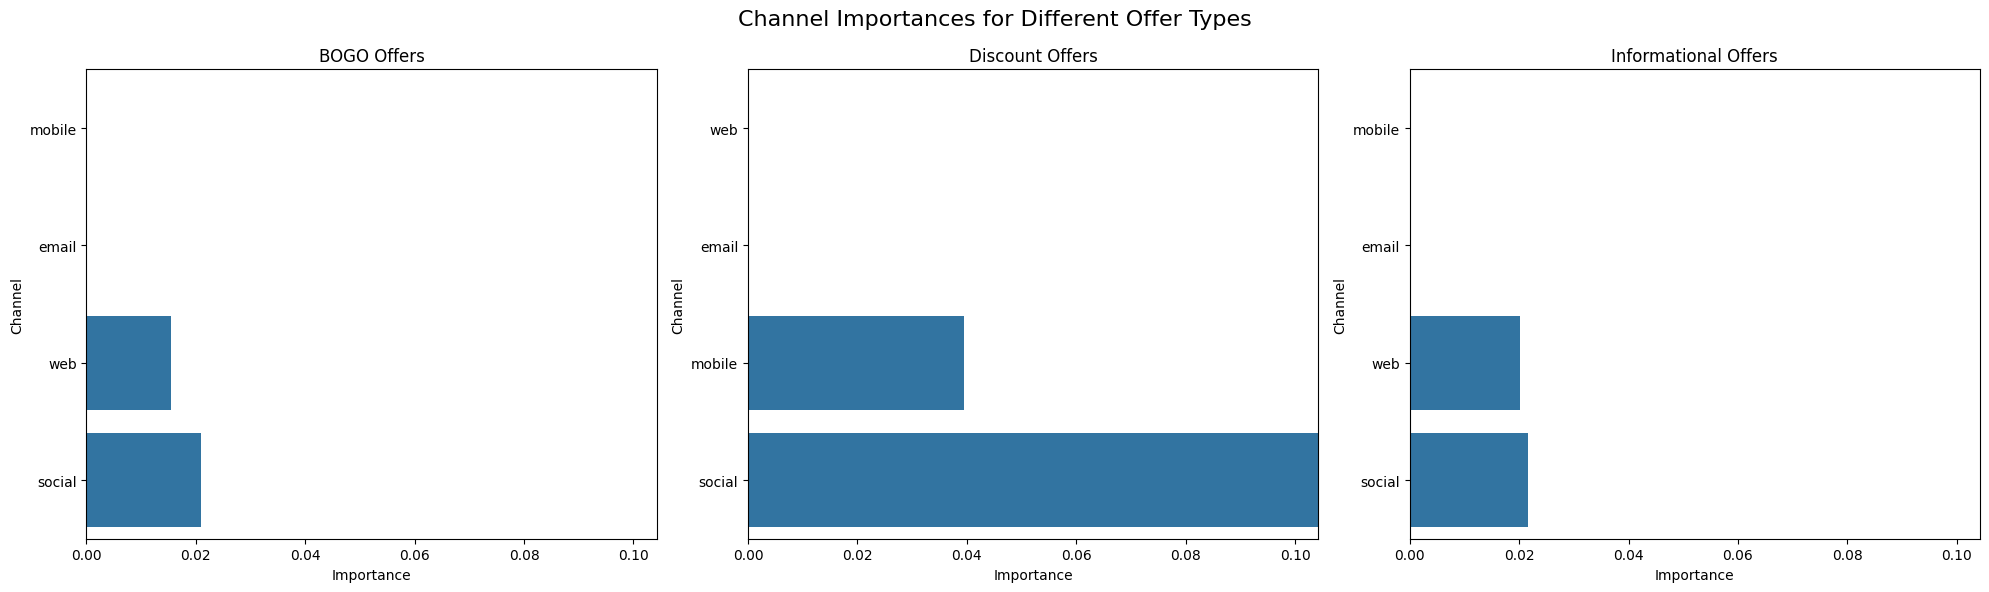

In [42]:
def analyze_offer_type_rf(df, offer_type):
    """
    Performs Random Forest analysis on offer data and returns channel importances.

    Parameters:
    df (pandas.DataFrame): Dataframe containing offer data.
    offer_type (str): Type of offer ('BOGO', 'Discount', or 'Informational').

    Return:
    pandas.DataFrame: Channel importances
    """
    print(f"\nRandom Forest Analysis for {offer_type.upper()} Offers:")
    
    features = ['age', 'income', 'male', 'female', 'membership_days', 'web', 'email', 'mobile', 'social']
    X = df[features]
    
    y = df['transaction_after_view_num'] if offer_type.lower() == 'informational' else df['offer_completed_in_time2']
    
    scaler = StandardScaler()
    X[['age', 'income', 'membership_days']] = scaler.fit_transform(X[['age', 'income', 'membership_days']])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    
    importances = pd.DataFrame({'feature': features, 'importance': rf.feature_importances_})
    importances = importances.sort_values('importance', ascending=False)
    print("\nFeature Importances:")
    print(importances)
    
    channel_importances = importances[importances['feature'].isin(['web', 'email', 'mobile', 'social'])]
    channel_importances = channel_importances.sort_values('importance', ascending=True)
    
    return channel_importances

# Analyze all offer types
bogo_importances = analyze_offer_type_rf(df_bogo, "BOGO")
discount_importances = analyze_offer_type_rf(df_discount, "Discount")
informational_importances = analyze_offer_type_rf(df_informational, "Informational")

# Create a single figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Channel Importances for Different Offer Types', fontsize=16)

# Function to plot channel importances
def plot_channel_importances(ax, importances, title):
    sns.barplot(x='importance', y='feature', data=importances, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Importance')
    ax.set_ylabel('Channel')

# Plot for each offer type
plot_channel_importances(ax1, bogo_importances, 'BOGO Offers')
plot_channel_importances(ax2, discount_importances, 'Discount Offers')
plot_channel_importances(ax3, informational_importances, 'Informational Offers')

# Set the same x-axis limit for all subplots
max_importance = max(
    bogo_importances['importance'].max(),
    discount_importances['importance'].max(),
    informational_importances['importance'].max()
)

ax1.set_xlim(0, max_importance)
ax2.set_xlim(0, max_importance)
ax3.set_xlim(0, max_importance)

plt.tight_layout()
plt.show()

# Result Question c):

Bogo: 
Precision: For non-completions, 72% of predicted non-completions were correct. For completions, 51% of predicted completions were correct.
Recall: The model correctly identified 79% of actual non-completions and 41% of actual completions.
Accuracy: Overall, the model correctly classified 66% of all cases.
The model performs better at predicting non-completions than completions.
Looking at the channels: Social media as a channel has a small but noticeable importance (2.1%). Web as a channel has very little importance (1.6%).

Discount:
Precision: For non-completions, 72% of predicted non-completions were correct. For completions, 62% of predicted completions were correct.
Recall: The model correctly identified 77% of actual non-completions and 57% of actual completions.
Accuracy: Overall, the model correctly classified 68% of all cases.
The model performs slightly better at predicting when a discount offer won't be completed.
Looking at the channels: Social media channel has notable importance (10.4%), Mobile channel has some importance (3.4%), while email and web channels have no impact on the success of an discount offer.)


Informational:
Precision: For non-completions 71% of predicted negatives were correct. For completions, 55% of predicted positives were correct.
Recall: The model correctly identified 78% of actual negatives and 46% of actual positives.
Accuracy: Overall, the model correctly classified 66% of all cases.
The model performs better at predicting when a transaction won't occur after viewing an informational offer.
Looking at the channels: Social media and web channels have minor importance (about 2% each). Email and mobile channels have zero importance in this model for informational offers.

Overall, the accuracy/prediction power of this model is much higher than in the logistic regression.  

Overall channel effectiveness across offer types:
Social Media: Consistently important across all offer types, with the highest impact on discount offers.
Mobile: Significant for discount offers but negligible for BOGO and informational offers.
Web: Minor importance for BOGO and informational offers, ineffective for discount offers.
Email: Consistently shows little to no importance across all offer types.


# Recommendations for optimal offering:
Starbucks should prioritize social media marketing, especially for discount offers.
It should leverage mobile channels for discount offers specifically and investigate why web channels are ineffective for discount offers despite having some impact on other offer types.
It should consider tailoring channel strategies distinctly for each offer type, given the varying importance of channels across BOGO, discount, and informational offers.
It should think about loyalty programs, given the high importance of membership duration and invest in strategies to increase customer loyalty and retention.



# Further potential analysis:
Further investigation of why email and web channels show little to no importance, could be useful (Is this due to how they're used, or are there data issues?)
Interaction features could be included e.g., between channels and customer characteristics, to see if this improves the model.
It could be considered that customers might be exposed to offers by multiple channels before completing an offer. 
An A/B testing could be conducted:A controlled experiment in which randomly assigned customers receive offers through different channels and the results are then compared. 
A content analysis could also help to analyse if certain contents/products are more effectively advertised through a specific channel. 


